## O Problema

-- Objetivo do Problema:

    -- 1.0. Previsão do primeiro destino que um novo usuário irá escolher
    
    -- Porque?
    
        -- Qual o tipo de modelo de negócio do Airbnb?
        
            -- Marketplace - Demanda x Oferta (Conectar pessoas que oferecem acomodação, com pessoas que estão procurando acomodação)
            
            -- Oferta (pessoas oferecendo acomodação)
            
                -- Métricas:
                
                    -- Tamanho do portifólio (país x cidade)
                    
                    -- Diversidade/Densidade de portifólio (Dentro de um país existem acomodações em todas as cidades ou só em algumas)
                    
                    -- Preço médio
                    
                -- Demanda (pessoas procurando acomodação):
                
                    -- Número de usuários
                    
                    -- Quanto o usuário gasta na plataforma
                    
                    -- Custo por cliente
                    
                     Receita = (Preço médio de comissão * Número de clientes) - Custo por cliente

-- Proposta da solução

    -- Modelo de previsão do primeiro destino de um novo usuário.
    
    -- Predições armazenadas em uma tabela no banco de dados.
    
    -- API
    
        -- Input: usuário e suas características.
        
        -- Output: usuário e suas características com a predição do destino.

# <font color=red> Ciclo-01 </font>

## 0.0. Importação

In [61]:
import pandas as pd
from sklearn import preprocessing as pp
from sklearn import metrics as m
from scikitplot import metrics as mt
import random
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from scipy import stats as ss

# Rede Neural
from sklearn import model_selection as ms
from keras import models as ml
from keras import layers as l

### 0.1. Funções

In [60]:
def cramer_v(x, y):
    cm = pd.crosstab(x, y).values
    n = cm.sum()
    r, k = cm.shape
    
    chi2 = ss.chi2_contingency(cm)[0] # resultado do teste chi2 baseado no pearson
    chi2corr = max( 0, chi2 - (k-1) *(r-1)/(n-1))
    
    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1)
    
    return np.sqrt((chi2corr/n) / (min(kcorr-1, rcorr-1)))

### 0.2. Carregando Dados

In [3]:
df_raw_users = pd.read_csv('dataset/training_users.csv', low_memory=True) #low_memory: carregar os dados em batchs
df_raw_users.shape

(213451, 16)

In [4]:
df_raw_sessions = pd.read_csv('dataset/sessions.csv', low_memory=True)
df_raw_sessions.shape

(10567737, 6)

In [43]:
#df_sessions[['action','user_id']].groupby('action').count()
#df_sessions[['user_id','action']].value_counts()

## 1.0. Descrição dos Dados

In [5]:
df1_users = df_raw_users.copy()
df1_sessions = df_raw_sessions.copy()

### 1.1. Dimensão dos Dados

In [7]:
print(f'Número de linhas df_users: {df1_users.shape[0]}')
print(f'Número de colunas df_users : {df1_users.shape[1]}')

Número de linhas df_users: 213451
Número de colunas df_users : 16


In [8]:
print(f'Número de linhas df_sessions: {df1_sessions.shape[0]}')
print(f'Número de colunas df_sessions: {df1_sessions.shape[1]}')

Número de linhas df_sessions: 10567737
Número de colunas df_sessions: 6


In [47]:
df1_users.sample(5)

,id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination
186726,x9hdvbiq7p,2014-05-09,20140509153048,NaN,-unknown-,NaN,basic,25,en,direct,direct,untracked,iOS,iPhone,-unknown-,NDF
103112,5jqiy132ar,2013-08-28,20130828180328,NaN,-unknown-,NaN,basic,0,de,seo,google,linked,Web,Windows Desktop,Firefox,NDF
74109,mts3v59w5v,2013-04-30,20130430223826,NaN,FEMALE,31.0,basic,0,en,other,other,untracked,Web,Mac Desktop,Safari,NDF
61063,sgqwdjvh68,2013-02-18,20130218231305,NaN,MALE,28.0,basic,0,en,direct,direct,untracked,Web,Windows Desktop,Chrome,NDF
27696,0leuip89lx,2012-06-14,20120614061300,NaN,FEMALE,39.0,basic,0,en,other,craigslist,tracked-other,Web,Windows Desktop,IE,NDF


In [48]:
df1_sessions.sample(5)

,user_id,action,action_type,action_detail,device_type,secs_elapsed
8007536,04uh49i88z,show,view,user_profile,iPhone,7212.0
8008461,fa1a7ha1y2,similar_listings_v2,NaN,NaN,Windows Desktop,736.0
1343386,93xdjg0oms,ask_question,submit,contact_host,Windows Desktop,528.0
2922828,s3vy9o9xwx,index,view,view_search_results,Windows Desktop,1308.0
1131633,dd8udoqs00,personalize,data,wishlist_content_update,Windows Desktop,29.0


### 1.2. Tipo de Dados

In [9]:
df1_users.dtypes

id                          object
date_account_created        object
timestamp_first_active       int64
date_first_booking          object
gender                      object
age                        float64
signup_method               object
signup_flow                  int64
language                    object
affiliate_channel           object
affiliate_provider          object
first_affiliate_tracked     object
signup_app                  object
first_device_type           object
first_browser               object
country_destination         object
dtype: object

In [10]:
df1_sessions.dtypes

user_id           object
action            object
action_type       object
action_detail     object
device_type       object
secs_elapsed     float64
dtype: object

### 1.3. Verificando NA

In [11]:
df1_users.isna().sum() / len(df1_users)

id                         0.000000
date_account_created       0.000000
timestamp_first_active     0.000000
date_first_booking         0.583473
gender                     0.000000
age                        0.412226
signup_method              0.000000
signup_flow                0.000000
language                   0.000000
affiliate_channel          0.000000
affiliate_provider         0.000000
first_affiliate_tracked    0.028414
signup_app                 0.000000
first_device_type          0.000000
first_browser              0.000000
country_destination        0.000000
dtype: float64

In [12]:
df1_sessions.isna().sum() / len(df1_sessions)

user_id          0.003264
action           0.007535
action_type      0.106570
action_detail    0.106570
device_type      0.000000
secs_elapsed     0.012872
dtype: float64

In [13]:
# validando a classificação dos usuários que não tem data da primeira reserva
aux = df1_users[df1_users['date_first_booking'].isna()]
aux['country_destination'].value_counts(normalize=True)

NDF    1.0
Name: country_destination, dtype: float64

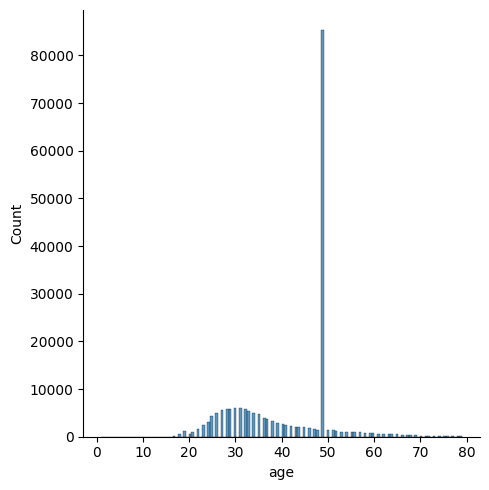

In [30]:
# validando as idades
aux = df1_users[df1_users['age'].isna()]
#aux['country_destination'].value_counts(normalize=True)
sns.displot(df1_users[df1_users['age'] < 80]['age'])

In [15]:
# validando first_affiliate_tracked
df1_users['first_affiliate_tracked'].drop_duplicates()

0            untracked
5                  omg
12                 NaN
13              linked
79       tracked-other
257            product
6270         marketing
11184        local ops
Name: first_affiliate_tracked, dtype: object

In [16]:
# Removendo valores nulos
# =================== Users ===================
# date_first_booking
date_first_booking_max = pd.to_datetime(df1_users['date_first_booking']).max().strftime('%Y-%m-%d')
df1_users['date_first_booking'] = df1_users['date_first_booking'].fillna(date_first_booking_max)

# age
avg_age = df1_users['age'].mean().astype(int)
df1_users['age'] = df1_users['age'].fillna(avg_age)

# first_affiliate_tracked
df1_users = df1_users[~df1_users['first_affiliate_tracked'].isna()]

# =================== Sessions ===================
# user_id - 0,3%
df1_sessions = df1_sessions[~df1_sessions['user_id'].isna()]

# action - 0,7%
df1_sessions = df1_sessions[~df1_sessions['action'].isna()]

# action_type - 11%
df1_sessions = df1_sessions[~df1_sessions['action_type'].isna()]

# action_detail - 11%
df1_sessions = df1_sessions[~df1_sessions['action_detail'].isna()]

# secs_elapsed - 1,2%
df1_sessions = df1_sessions[~df1_sessions['secs_elapsed'].isna()]

### 1.4. Alterando Tipo de Dados

In [17]:
# date_account_created
df1_users['date_account_created'] = pd.to_datetime(df1_users['date_account_created'])

# timestamp_first_active
df1_users['timestamp_first_active'] = pd.to_datetime(df1_users['timestamp_first_active'], format='%Y%m%d%H%M%S')

# date_first_booking
df1_users['date_first_booking'] = pd.to_datetime(df1_users['date_first_booking'])

# gender

# age
df1_users['age'] = df1_users['age'].astype(int)

### 1.5. Verificando Balanceamento de Dados

In [18]:
df1_users['country_destination'].value_counts(normalize=True)

NDF      0.579673
US       0.294461
other    0.048128
FR       0.023623
IT       0.013458
GB       0.011066
ES       0.010671
CA       0.006707
DE       0.005020
NL       0.003621
AU       0.002541
PT       0.001032
Name: country_destination, dtype: float64

### 1.6. Análise Descritiva

In [48]:
# =================== Users ===================
num_attributes_users = df1_users.select_dtypes(include=['int64', 'float64'])
cat_attributes_users = df1_users.select_dtypes(exclude=['int64', 'float64','datetime64[ns]'])
date_attributes_users = df1_users.select_dtypes(exclude=['datetime64[ns]'])

# =================== Sessions ===================
num_attributes_sessions = df1_sessions.select_dtypes(include=['int64', 'float64'])
cat_attributes_sessions = df1_sessions.select_dtypes(exclude=['int64', 'float64','datetime64[ns]'])
date_attributes_sessions = df1_sessions.select_dtypes(exclude=['datetime64[ns]'])

### 1.6.1. Numérico - Users

In [47]:
num_attributes_users.describe().T

,count,mean,std,min,25%,50%,75%,max
age,207386.0,49.183142,118.421975,1.0,32.0,49.0,49.0,2014.0
signup_flow,207386.0,3.151490,7.543933,0.0,0.0,0.0,0.0,25.0


### 1.6.2. Numérico - Sessions

In [50]:
num_attributes_sessions.describe().T

,count,mean,std,min,25%,50%,75%,max
secs_elapsed,9213930.0,19961.8251,88849.39327,0.0,333.0,1369.0,9796.0,1799977.0


### 1.6.3. Categórico - Users

In [57]:
cat_attributes_users.drop('id', axis=1).describe()

,gender,signup_method,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination
count,207386,207386,207386,207386,207386,207386,207386,207386,207386,207386
unique,4,3,25,8,18,7,4,9,52,12
top,-unknown-,basic,en,direct,direct,untracked,Web,Mac Desktop,Chrome,NDF
freq,91783,148297,200415,134179,133935,109232,178334,89600,63845,120216


### 1.6.4. Categórico - Sessions

In [58]:
cat_attributes_sessions.drop('user_id', axis=1).describe()

,action,action_type,action_detail,device_type
count,9213930,9213930,9213930,9213930
unique,347,10,155,14
top,show,view,view_search_results,Mac Desktop
freq,2178382,3545621,1770931,3019523


In [65]:
# Recuperando os atributos da sessões
cat_attributes_sessions_list = cat_attributes_sessions.drop('user_id', axis = 1).columns.tolist()

corr_dict = {}
for i in range(len(cat_attributes_sessions_list)):
    corr_list = []
    for j in range(len(cat_attributes_sessions_list)):
        ref = cat_attributes_sessions_list[i]
        feat = cat_attributes_sessions_list[j]
        
        # correlação
        corr = cramer_v(cat_attributes_sessions[ref], cat_attributes_sessions[feat])
        
        # adicionar a lista
        corr_list.append(corr)
    
    # adiciona a lista de correlação para cada atributo de referência
    corr_dict[ref] = corr_list

<AxesSubplot: >

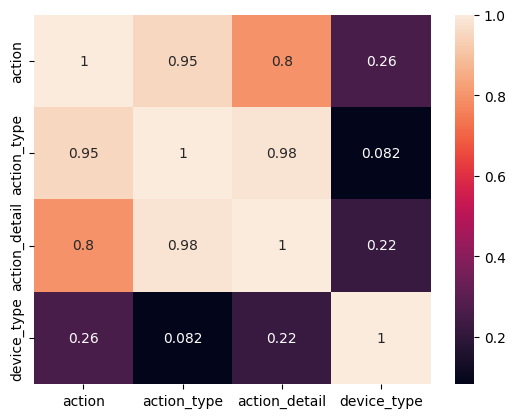

In [66]:
d = pd.DataFrame(corr_dict)
d = d.set_index(d.columns)
sns.heatmap(d, annot=True)

In [56]:
#df1_sessions[df1_sessions['user_id'].isna()].sample(5)
#df1_sessions.info()
#df1_sessions[df1_sessions['user_id'].isna()].sample(5)
#df1_users[df1_users['age'] > 100]['country_destination'].value_counts().sum() / len(df1_users)

## 2.0. Feature Emgineering

In [81]:
df2_users = df1_users.copy()

### 2.1. Criar Novas Features

In [86]:
# Dias da primeira ativação até a reserva
df2_users['first_active'] = pd.to_datetime(df2_users['timestamp_first_active'].dt.strftime('%Y-%m-%d'))
df2_users['days_from_first_active_until_booking'] = (df2_users['date_first_booking'] - df2_users['first_active']).apply(lambda x: x.days)

# Dias da primeira ativação até criar a conta
df2_users['days_from_first_acive_until_account_created'] = (df2_users['date_account_created'] - df2_users['first_active']).apply(lambda x: x.days)

# Dias  criação da conta até a reserva
df2_users['days_from_account_created_until_first_booking'] = (df2_users['date_first_booking'] - df2_users['date_account_created']).apply(lambda x: x.days)

# ======================== Primeira ativação ========================
# ano da primeira ativação
df2_users['year_first_active'] = df2_users['first_active'].dt.year

# mês da primeira ativação
df2_users['month_first_active'] = df2_users['first_active'].dt.month

# dia da primeira ativação
df2_users['day_first_active'] = df2_users['first_active'].dt.day

# di da semana da primeira ativação
df2_users['day_of_week_first_active'] = df2_users['first_active'].dt.dayofweek

# semana do ano da primeira ativação
df2_users['week_of_year_first_active'] = df2_users['first_active'].dt.weekofyear

# ======================== Primeira reserva ========================
# ano da primeira reserva
df2_users['year_first_booking'] = df2_users['date_first_booking'].dt.year

# mês da primeira reserva
df2_users['month_first_booking'] = df2_users['date_first_booking'].dt.month

# dia da primeira reserva
df2_users['day_first_booking'] = df2_users['date_first_booking'].dt.day

# di da semana da primeira reserva
df2_users['day_of_week_first_booking'] = df2_users['date_first_booking'].dt.dayofweek

# semana do ano da primeira reserva
df2_users['week_of_year_first_booking'] = df2_users['date_first_booking'].dt.weekofyear

# ======================== PConta criada ========================
# ano da conta criada
df2_users['year_account_created'] = df2_users['date_account_created'].dt.year

# mês da conta criada
df2_users['month_account_created'] = df2_users['date_account_created'].dt.month

# dia da conta criada
df2_users['day_account_created'] = df2_users['date_account_created'].dt.day

# di da semana da conta criada
df2_users['day_of_week_account_created'] = df2_users['date_account_created'].dt.dayofweek

# semana do ano da conta criada
df2_users['week_of_year_account_created'] = df2_users['date_account_created'].dt.weekofyear

/tmp/ipykernel_3361/2454343485.py:25: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  df2_users['week_of_year_first_active'] = df2_users['first_active'].dt.weekofyear
/tmp/ipykernel_3361/2454343485.py:41: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  df2_users['week_of_year_first_booking'] = df2_users['date_first_booking'].dt.weekofyear
/tmp/ipykernel_3361/2454343485.py:57: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  df2_users['week_of_year_account_created'] = df2_users['date_account_created'].dt.weekofyear


## 3.0. Filtrando os Dados

In [88]:
df3_users = df2_users.copy()

### 3.1. Filtrando Linhas

In [89]:
df3_users[df1_users['age'] < 15][['age', 'country_destination']].groupby('country_destination').count()

,age
country_destination,
DE,1
ES,1
IT,2
NDF,28
US,5
other,1


In [90]:
df3_users[df1_users['age'] > 120][['age', 'country_destination']].groupby('country_destination').count()

,age
country_destination,
AU,1
CA,6
DE,7
ES,9
FR,18
GB,10
IT,13
NDF,373
NL,5


In [91]:
df_join = pd.merge(df3_users, df1_sessions, left_on='id', right_on='user_id', how='left')
df_join[df_join['secs_elapsed'] == 0][['secs_elapsed','country_destination']].groupby('country_destination').count() / len(df1_sessions)

,secs_elapsed
country_destination,
AU,0.000027
CA,0.000070
DE,0.000025
ES,0.000113
FR,0.000188
GB,0.000109
IT,0.000156
NDF,0.004563
NL,0.000043


In [92]:
# age - aparentemente existem inputs incorretos e representam uma quantidade muito baixa na base de dados
df3_users = df3_users[(df3_users['age'] > 15) & (df3_users['age'] < 120)]

# secs_elapsed - não existe a possibilidade do usuário se manter no site por 0 tempo
df3_sessions = df1_sessions[df1_sessions['secs_elapsed'] > 0]

### 3.2. Selecionando Colunas

## 4.0. Preparação dos Dados

In [93]:
df4_users = df3_users.copy()
df4_sessions = df3_sessions.copy()

In [94]:
# variáveis dummy
df4_users_dummy = pd.get_dummies(df4_users.drop(['id','country_destination'], axis=1))

# juntar id e country destination
df4_users = pd.concat([df4_users[['id','country_destination']], df4_users_dummy], axis=1)

## 5.0. Feature Selection

In [95]:
cols_drop = ['date_account_created','timestamp_first_active','date_first_booking', 'first_active'] #dados originais
df5_users = df4_users.drop(cols_drop, axis=1)

In [96]:
X = df5_users.drop('country_destination', axis=1)
y = df5_users['country_destination'].copy()

In [97]:
# Separando dataset em treino e teste
X_train, X_test, y_train, y_test = ms.train_test_split(X, y, test_size=0.2, random_state=32)

## 5.0. Modelos de Machine Learning

In [100]:
x_train = X_train.drop('id', axis=1)
x_test = X_test.drop('id', axis=1)

#y_test_nn = y_test.to_numpy()

### 5.1. Baseline Model

In [64]:
# Lista das classes
country_destination_list = df1_users['country_destination'].drop_duplicates().sort_values().tolist()

# Total de registros de test
k_num = y_test.shape[0]

# Quantidade de registros por classe - será utilizado como peso para gerar aleatoriedade de acordo com a base
country_destination_weights = df1_users['country_destination'].value_counts(normalize=True).sort_index().tolist()

# Modelo aleatório
yhat_random = random.choices(population=country_destination_list, weights=country_destination_weights, k=k_num)
len(yhat_random)

13635

Accuracy: 0.514998166483315
Balanced Accuracy: 0.08723910110054071
Kappa Metrics: -0.0024646855608103646


<AxesSubplot: title={'center': 'Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

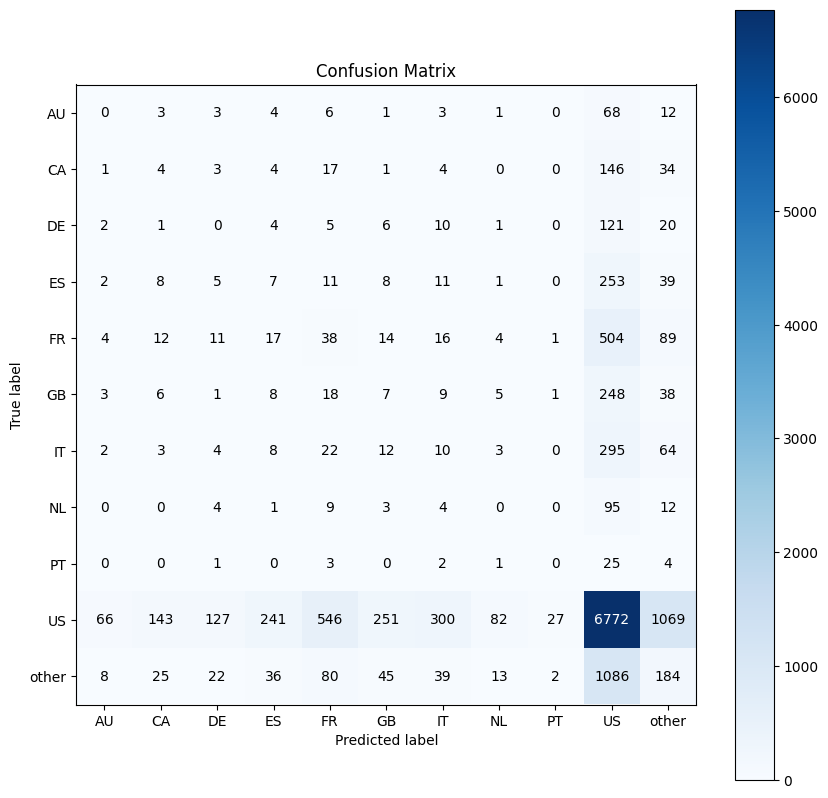

In [65]:
# Accuracy
acc_random = m.accuracy_score(y_test, yhat_random)
print(f'Accuracy: {acc_random}')

# Balanced Accuracy
balanced_acc_random = m.balanced_accuracy_score(y_test, yhat_random)
print(f'Balanced Accuracy: {balanced_acc_random}')

# Kappa Metrics
kappa_random = m.cohen_kappa_score(y_test, yhat_random)
print(f'Kappa Metrics: {kappa_random}')

# Confusion Matrix
mt.plot_confusion_matrix(y_test, yhat_random, normalize=False, figsize=(10,10))

### 5.2. Neural Network - MLP

In [101]:
# transformando valores da classificação para RN
ohe = pp.OneHotEncoder()
y_train_nn = ohe.fit_transform(y_train.values.reshape(-1, 1)).toarray()

In [102]:
# model definition
model = ml.Sequential()
model.add(l.Dense(256, input_dim=x_train.shape[1], activation = 'relu'))
model.add(l.Dense(12, activation='softmax'))

# model compile
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics='accuracy')

# train model
model.fit(x_train, y_train_nn, epochs=100)

Epoch 1/100


2023-01-23 14:32:15.887688: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 198328800 exceeds 10% of free system memory.


5165/5165 [==============================] - 8s 1ms/step - loss: 4.8162 - accuracy: 0.7924
Epoch 2/100
5165/5165 [==============================] - 7s 1ms/step - loss: 1.3029 - accuracy: 0.8176
Epoch 3/100
5165/5165 [==============================] - 7s 1ms/step - loss: 0.6399 - accuracy: 0.8538
Epoch 4/100
5165/5165 [==============================] - 7s 1ms/step - loss: 0.5075 - accuracy: 0.8730
Epoch 5/100
5165/5165 [==============================] - 7s 1ms/step - loss: 0.4994 - accuracy: 0.8732
Epoch 6/100
5165/5165 [==============================] - 7s 1ms/step - loss: 0.4980 - accuracy: 0.8733
Epoch 7/100
5165/5165 [==============================] - 7s 1ms/step - loss: 0.4976 - accuracy: 0.8732
Epoch 8/100
5165/5165 [==============================] - 7s 1ms/step - loss: 0.4964 - accuracy: 0.8735
Epoch 9/100
5165/5165 [==============================] - 7s 1ms/step - loss: 0.4955 - accuracy: 0.8734
Epoch 10/100
5165/5165 [==============================] - 7s 1ms/step - loss: 0.4952 

Epoch 80/100
5165/5165 [==============================] - 7s 1ms/step - loss: 0.4906 - accuracy: 0.8738
Epoch 81/100
5165/5165 [==============================] - 7s 1ms/step - loss: 0.4905 - accuracy: 0.8738
Epoch 82/100
5165/5165 [==============================] - 7s 1ms/step - loss: 0.4907 - accuracy: 0.8738
Epoch 83/100
5165/5165 [==============================] - 7s 1ms/step - loss: 0.4910 - accuracy: 0.8737
Epoch 84/100
5165/5165 [==============================] - 7s 1ms/step - loss: 0.4909 - accuracy: 0.8738
Epoch 85/100
5165/5165 [==============================] - 7s 1ms/step - loss: 0.4906 - accuracy: 0.8737
Epoch 86/100
5165/5165 [==============================] - 7s 1ms/step - loss: 0.4912 - accuracy: 0.8737
Epoch 87/100
5165/5165 [==============================] - 7s 1ms/step - loss: 0.4907 - accuracy: 0.8737
Epoch 88/100
5165/5165 [==============================] - 7s 1ms/step - loss: 0.4904 - accuracy: 0.8738
Epoch 89/100
5165/5165 [==============================] - 7s 1ms

### 5.2.1. NN Performance

In [103]:
# predição
pred_nn = model.predict(x_test)

# inverter valores dummy para os classificadores da predição
yhat_nn = ohe.inverse_transform(pred_nn)

# preparar predição
yhat_nn = yhat_nn.reshape(1, -1)[0]
y_test_nn = y_test.to_numpy()

1292/1292 [==============================] - 1s 839us/step


Accuracy: 0.8754326096952976
Balanced Accuracy: 0.1666394535608349
Kappa Metrics: 0.7692558653555841


<AxesSubplot: title={'center': 'Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

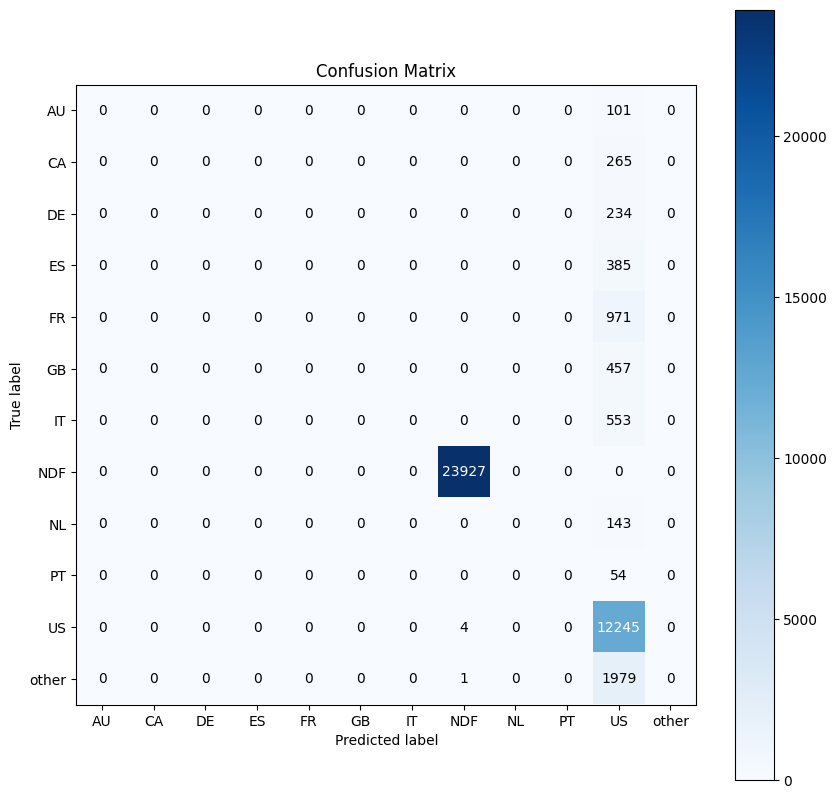

In [104]:
# Accuracy
acc_nn = m.accuracy_score(y_test_nn, yhat_nn)
print(f'Accuracy: {acc_nn}')

# Balanced Accuracy
balanced_acc_nn = m.balanced_accuracy_score(y_test_nn, yhat_nn)
print(f'Balanced Accuracy: {balanced_acc_nn}')

# Kappa Metrics
kappa_nn = m.cohen_kappa_score(y_test_nn, yhat_nn)
print(f'Kappa Metrics: {kappa_nn}')

# Confusion Matrix
mt.plot_confusion_matrix(y_test_nn, yhat_nn, normalize=False, figsize=(10,10))

### 5.2.3. NN Performance - Cross-Validation

In [72]:
# gerar k-fold
num_folds = 5
kfold = ms.StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=32)

balanced_acc_list = []
kappa_acc_list = []

i = 1
for train_ix, val_ix in kfold.split(x_train, y_train):
    print(f'Numero Fold: {i}/{num_folds}')
    
    # recuperar fold
    x_train_fold = x_train.iloc[train_ix]
    y_train_fold = y_train.iloc[train_ix]
    
    x_val_fold = x_train.iloc[val_ix]
    y_val_fold = y_train.iloc[val_ix]
    
    # target hot-encoding
    ohe = pp.OneHotEncoder()
    y_train_fold_nn = ohe.fit_transform(y_train_fold.values.reshape(-1, 1)).toarray()

    # definir modelo
    model = ml.Sequential()
    model.add(l.Dense(256, input_dim=x_train.shape[1], activation='relu'))
    model.add(l.Dense(11, activation='softmax'))

    # compilar modelo
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    # treinar modelo
    model.fit(x_train_fold, y_train_fold_nn, epochs=100, batch_size=32, verbose=0)

    # predição
    pred_nn = model.predict(x_val_fold)
    yhat_nn = ohe.inverse_transform(pred_nn)
    
    # preparar dados
    y_test_nn = y_val_fold.to_numpy()
    yhat_nn = ohe.inverse_transform(pred_nn)

    # métricas
    
    ## Balanced Accuracy
    balanced_acc_nn = m.balanced_accuracy_score(y_test_nn, yhat_nn)
    balanced_acc_list.append(balanced_acc_nn)
    
    ## Kappa Metrics
    kappa_acc_nn = m.cohen_kappa_score(y_test_nn, yhat_nn)
    kappa_acc_list.append(kappa_acc_nn)
    
    i += 1
    

Numero Fold: 1/5


2023-01-19 17:01:00.887082: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 39090688 exceeds 10% of free system memory.


341/341 [==============================] - 0s 960us/step
Numero Fold: 2/5
341/341 [==============================] - 0s 854us/step
Numero Fold: 3/5
341/341 [==============================] - 0s 885us/step
Numero Fold: 4/5
341/341 [==============================] - 0s 868us/step
Numero Fold: 5/5
341/341 [==============================] - 0s 831us/step


In [95]:
print(f'Media Balanced Accuracy: {np.round(np.mean(balanced_acc_list), 4)} +/- {np.round(np.std(balanced_acc_list), 4)}')
print(f'Media Kappa: {np.round(np.mean(kappa_acc_list), 4)} +/- {np.round(np.std(kappa_acc_list), 4)}')

Media Balanced Accuracy: 0.0916 +/- 0.0002
Media Kappa: 0.0035 +/- 0.0022
